In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
df = pd.read_csv('output.csv') #讀取數據

df['price'] = df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float) 
df['rent'] = pd.to_numeric(df['rent'].replace({'\$': '', ',': ''}, regex=True), errors='coerce')
#處理rent跟price，轉換成int 

numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())#對缺失值用均值做填補


df = pd.get_dummies(df, columns=['Street Name', 'City', 'State'], drop_first=True)#對類別型資料做one-Hot編碼

scaler = StandardScaler()
df[['bedrooms', 'bathrooms', 'area']] = scaler.fit_transform(df[['bedrooms', 'bathrooms', 'area']])#對數值型資料標準化

df.to_csv('processed_output.csv', index=False)
df = pd.read_csv('processed_output.csv') 



<>:5: SyntaxWarning: invalid escape sequence '\$'
<>:6: SyntaxWarning: invalid escape sequence '\$'
<>:5: SyntaxWarning: invalid escape sequence '\$'
<>:6: SyntaxWarning: invalid escape sequence '\$'
/var/folders/0r/s9_2vrjn5qjdcr7gpx6_sd480000gn/T/ipykernel_22687/3910868716.py:5: SyntaxWarning: invalid escape sequence '\$'
  df['price'] = df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
/var/folders/0r/s9_2vrjn5qjdcr7gpx6_sd480000gn/T/ipykernel_22687/3910868716.py:6: SyntaxWarning: invalid escape sequence '\$'
  df['rent'] = pd.to_numeric(df['rent'].replace({'\$': '', ',': ''}, regex=True), errors='coerce')


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

<font size="5">1.使用RandomForestRegressor

In [13]:


X = df.drop('price', axis=1)  # 刪除price，其他用於訓練模型
y = df['price']  # 預測目標


model = RandomForestRegressor(random_state=50)


cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error') #k-fold

mse_scores = -cv_scores  # 需要取反
mean_mse = np.mean(mse_scores)  
rmse_scores = np.sqrt(mean_mse) #RMSE

print(f" RMSE: {rmse_scores}")



 RMSE: 58944.173896578504


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

<font size="5">2.使用LinearRegression

In [15]:
model = LinearRegression()
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -cv_scores  # 需要取反
mean_mse = np.mean(mse_scores)

rmse_scores = np.sqrt(mean_mse)

print(f"RMSE: {rmse_scores}")

RMSE: 15149996968586.094


<font size="5">3.使用lightGBM

In [16]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

In [17]:
# 参数列表
param_grid = [
    {'num_leaves': 31, 'learning_rate': 0.1, 'max_depth': 10},
    {'num_leaves': 50, 'learning_rate': 0.05, 'max_depth': 15},
    {'num_leaves': 100, 'learning_rate': 0.01, 'max_depth': 20},
]

# 保存每组参数的 RMSE
results = []

# 遍历参数组合
for params in param_grid:
    model = lgb.LGBMRegressor(
        boosting_type='gbdt',
        objective='regression',
        metric='rmse',
        n_estimators=1000,
        verbose=-1,  # 去掉输出
        **params  
    )
    
    # 交叉验证
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    mse_scores = -cv_scores  # 转为正的 MSE
    rmse_scores = np.sqrt(mse_scores)  # 计算 RMSE
    mean_rmse = np.mean(rmse_scores)  # 平均 RMSE

    # 保存结果
    results.append({'params': params, 'rmse': rmse_scores, 'mean_rmse': mean_rmse})

# 输出结果
for result in results:
    print(f"Parameters: {result['params']}")
    print(f"RMSE for each fold: {result['rmse']}")
    print(f"Mean RMSE: {result['mean_rmse']}")
    print('-' * 50)


Parameters: {'num_leaves': 31, 'learning_rate': 0.1, 'max_depth': 10}
RMSE for each fold: [71321.81714759 95740.65851196 50617.90153376 85810.17161214
 53258.582987  ]
Mean RMSE: 71349.82635848713
--------------------------------------------------
Parameters: {'num_leaves': 50, 'learning_rate': 0.05, 'max_depth': 15}
RMSE for each fold: [71407.20416116 86293.81624734 49043.76573774 81637.53322138
 55508.97146008]
Mean RMSE: 68778.25816554143
--------------------------------------------------
Parameters: {'num_leaves': 100, 'learning_rate': 0.01, 'max_depth': 20}
RMSE for each fold: [67942.69083853 73548.61066192 47188.27794134 73457.83049417
 55601.23763959]
Mean RMSE: 63547.729515110725
--------------------------------------------------


<font size="5">4.使用XGBoost

In [18]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


In [ ]:

# 参数列表
param_grid = [
    {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1},
    {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05},
    {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.01},
]

# 保存每组参数的 RMSE
results = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 遍历参数组合
for params in param_grid:
    rmse_scores = []
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            verbosity=0,  # 禁止输出信息
            **params
        )
        
        # 使用早停机制训练模型 (手动控制早停)
        best_rmse = float('inf')
        best_round = 0
        for round in range(params['n_estimators']):
            model.fit(X_train, y_train, xgb_model=model.get_booster() if round > 0 else None)
            y_pred = model.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            
            if rmse < best_rmse:
                best_rmse = rmse
                best_round = round
            elif round - best_round > 50:  # 停止条件：50轮没有改进
                break
        
        rmse_scores.append(best_rmse)
    
    # 保存结果
    mean_rmse = np.mean(rmse_scores)
    results.append({'params': params, 'rmse': rmse_scores, 'mean_rmse': mean_rmse})

# 输出结果
for result in results:
    print(f"Parameters: {result['params']}")
    print(f"RMSE for each fold: {result['rmse']}")
    print(f"Mean RMSE: {result['mean_rmse']}")
    print('-' * 50)


Parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
RMSE for each fold: [48821.883745979765, 54348.160353755135, 45417.10635333511, 39251.343676095625, 52022.0507335391]
Mean RMSE: 47972.10897254095
--------------------------------------------------
Parameters: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05}
RMSE for each fold: [47544.77644324062, 54891.484340450144, 45599.06197739437, 40088.629977273944, 51774.075529806316]
Mean RMSE: 47979.60565363307
--------------------------------------------------
Parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.01}
RMSE for each fold: [46542.62256998978, 56102.80112468333, 46164.1494392658, 40280.849577393616, 50242.8790128673]
Mean RMSE: 47866.66034483997
--------------------------------------------------


<font size="5">5.使用CatBoost

In [20]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import numpy as np


In [21]:

# 参数列表
param_grid = [
    {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'rsm': 0.8},
    {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 0.9, 'rsm': 0.7},
    {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8, 'rsm': 0.6}
]

# 保存每组参数的 RMSE
results = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 遍历参数组合
for params in param_grid:
    rmse_scores = []
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = CatBoostRegressor(
            loss_function='RMSE',
            verbose=0,  # 禁止输出信息
            **params
        )

        # 使用早停机制训练模型
        model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=False)

        # 计算验证集 RMSE
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)

    # 保存结果
    mean_rmse = np.mean(rmse_scores)
    results.append({'params': params, 'rmse': rmse_scores, 'mean_rmse': mean_rmse})

# 输出结果
for result in results:
    print(f"Parameters: {result['params']}")
    print(f"RMSE for each fold: {result['rmse']}")
    print(f"Mean RMSE: {result['mean_rmse']}")
    print('-' * 50)


Parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'rsm': 0.8}
RMSE for each fold: [48587.95592858327, 59917.24269935392, 51068.59740995034, 45063.16487884157, 56161.773531509156]
Mean RMSE: 52159.74688964765
--------------------------------------------------
Parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 0.9, 'rsm': 0.7}
RMSE for each fold: [48190.55576397098, 59440.570240086265, 47507.3353153279, 42660.844216187004, 54143.173481069985]
Mean RMSE: 50388.49580332843
--------------------------------------------------
Parameters: {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8, 'rsm': 0.6}
RMSE for each fold: [47272.87033110998, 58391.44162134664, 50367.02596979274, 45443.30347188202, 55483.81389665879]
Mean RMSE: 51391.69105815804
--------------------------------------------------


<font size = '5'>6.使用GBM

In [22]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

In [23]:
param_grid = [
    {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7, 'min_samples_split': 2, 'min_samples_leaf': 1},
    {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'subsample': 0.8, 'min_samples_split': 5, 'min_samples_leaf': 2},
    {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.03, 'subsample': 0.9, 'min_samples_split': 10, 'min_samples_leaf': 4},
]   #參數列表

results = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)


for params in param_grid:
    rmse_scores = []
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = GradientBoostingRegressor(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            learning_rate=params['learning_rate'],
            subsample=params['subsample']
        )

        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)

    mean_rmse = np.mean(rmse_scores)
    results.append({'params': params, 'rmse': rmse_scores, 'mean_rmse': mean_rmse})

for result in results:
    print(f"Parameters: {result['params']}")
    print(f"RMSE for each fold: {result['rmse']}")
    print(f"Mean RMSE: {result['mean_rmse']}")
    print('-' * 50)


Parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7, 'min_samples_split': 2, 'min_samples_leaf': 1}
RMSE for each fold: [51023.093041780514, 59665.20812844451, 47876.83310572971, 42758.045487458, 55561.92215267445]
Mean RMSE: 51377.020383217445
--------------------------------------------------
Parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'subsample': 0.8, 'min_samples_split': 5, 'min_samples_leaf': 2}
RMSE for each fold: [48971.78687244678, 57284.50806744383, 46542.809043059046, 41370.90440318233, 54619.03424292888]
Mean RMSE: 49757.80852581217
--------------------------------------------------
Parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.03, 'subsample': 0.9, 'min_samples_split': 10, 'min_samples_leaf': 4}
RMSE for each fold: [49369.7982166229, 58150.897263184284, 47583.832706556655, 40844.83550627061, 54017.7618283567]
Mean RMSE: 49993.425104198235
-----------------------------------------------

<font size = '5'>依據RMSE選擇參數 做soft voting

In [25]:
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor


catboost_model = CatBoostRegressor(
    loss_function='RMSE',
    verbose=0,  # 禁止输出信息
    n_estimators=300, max_depth=5, learning_rate=0.05, subsample=0.9, rsm=0.7
)


xgb_model = XGBRegressor(
    objective='reg:squarederror',
    verbosity=0,  # 禁止输出信息
    n_estimators=300, max_depth=7, learning_rate=0.01
)

lgb_model = lgb.LGBMRegressor(
    num_leaves=100, learning_rate=0.01, max_depth=20, n_estimators=100
)

gbm_model = GradientBoostingRegressor(
    n_estimators=200, max_depth=4, learning_rate=0.05, subsample=0.8, min_samples_split=5, min_samples_leaf=2
)

voting_model = VotingRegressor(estimators=[('catboost', catboost_model), 
                                           ('xgb', xgb_model), 
                                           ('lgb', lgb_model),
                                           ('gbm', gbm_model)])

results = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]


    voting_model.fit(X_train, y_train)


    y_pred = voting_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    results.append(rmse)


mean_rmse = np.mean(results)
print(f"Mean RMSE: {mean_rmse}")


Mean RMSE: 49617.612039489395


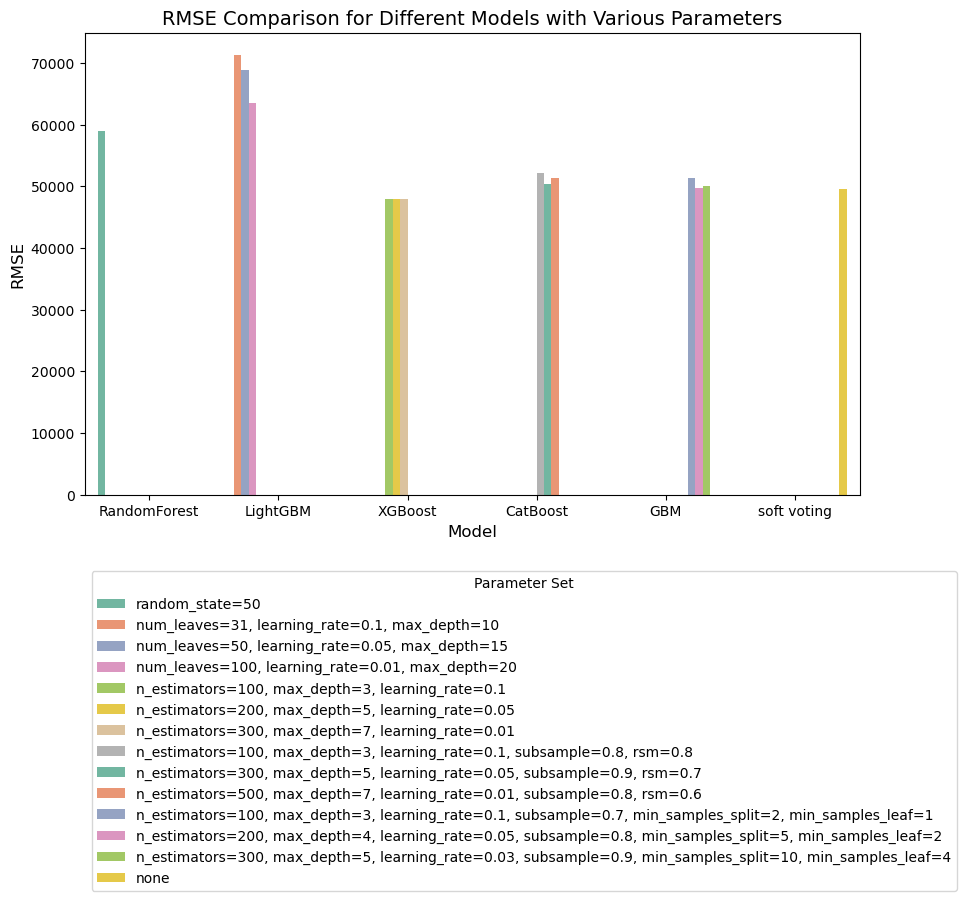

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 假设你有一个包含模型名称、参数组合和对应 RMSE 值的字典
results = [
    {'model': 'RandomForest','params':'random_state=50', 'rmse':58944.173896578504},
    {'model': 'LightGBM', 'params':'num_leaves=31, learning_rate=0.1, max_depth=10', 'rmse': 71349.82635848713},
    {'model': 'LightGBM', 'params':'num_leaves=50, learning_rate=0.05, max_depth=15', 'rmse': 68778.25816554143},
    {'model': 'LightGBM', 'params':'num_leaves=100, learning_rate=0.01, max_depth=20', 'rmse': 63547.729515110725},
    {'model': 'XGBoost', 'params':'n_estimators=100, max_depth=3, learning_rate=0.1', 'rmse': 47972.10897254095},
    {'model': 'XGBoost', 'params':'n_estimators=200, max_depth=5, learning_rate=0.05', 'rmse': 47979.60565363307},
    {'model': 'XGBoost', 'params':'n_estimators=300, max_depth=7, learning_rate=0.01', 'rmse': 47866.66034483997},
    {'model': 'CatBoost', 'params':'n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.8, rsm=0.8', 'rmse': 52159.74688964765},
    {'model': 'CatBoost', 'params':'n_estimators=300, max_depth=5, learning_rate=0.05, subsample=0.9, rsm=0.7', 'rmse': 50388.49580332843},
    {'model': 'CatBoost', 'params':'n_estimators=500, max_depth=7, learning_rate=0.01, subsample=0.8, rsm=0.6', 'rmse': 51391.69105815804},
    {'model': 'GBM', 'params':'n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.7, min_samples_split=2, min_samples_leaf=1', 'rmse': 51377.020383217445},
    {'model': 'GBM', 'params':'n_estimators=200, max_depth=4, learning_rate=0.05, subsample=0.8, min_samples_split=5, min_samples_leaf=2', 'rmse': 49757.80852581217},
    {'model': 'GBM', 'params':'n_estimators=300, max_depth=5, learning_rate=0.03, subsample=0.9, min_samples_split=10, min_samples_leaf=4', 'rmse': 49993.425104198235},
    {'model': 'soft voting', 'params': 'none', 'rmse':49617.612039489395}
]

df_results = pd.DataFrame(results)

plt.figure(figsize=(10, 6))

sns.barplot(x='model', y='rmse', data=df_results, hue='params', palette='Set2')


plt.title('RMSE Comparison for Different Models with Various Parameters', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('RMSE', fontsize=12)

# 显示图形
plt.legend(title='Parameter Set', bbox_to_anchor=(0, -0.15), loc='upper left')
plt.show()